In [17]:
from apps.advection import advection
from apps.advection.smoothscalarexample import smooth_scalar_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.visualize import plot

from IPython.display import HTML

# Smooth Scalar Advection Example

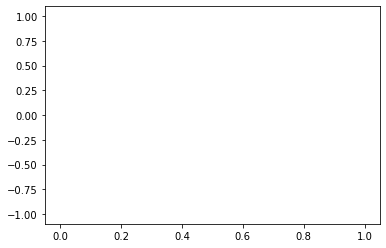

In [21]:
wavespeed = 1.0
initial_condition = x_functions.Sine()
problem = smooth_scalar_example.SmoothScalarExample(wavespeed, initial_condition)
problem.parameters["time_stepping"]["is_verbose"] = False
final_solution = main.run(problem)
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

# Convergence Test

## DG Convergence

In [7]:
wavespeed = 1.0
initial_condition = x_functions.Sine()
final_time = 1.0
exact_solution = advection.ExactSolution(initial_condition, wavespeed)
exact_final_solution = x_functions.FrozenT(exact_solution, final_time)

problem = smooth_scalar_example.SmoothScalarExample(wavespeed, initial_condition)
problem.parameters["final_time"] = final_time
problem.parameters["is_weak"] = True

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False

problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = 0.0
problem.parameters["mesh"]["x_right"] = 1.0

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [8]:
for num_basis_cpts in range(1, 5):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = dg_utils.standard_cfls(num_basis_cpts)
    error_list = []
    for num_elems in [20, 40]:
        problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, wavespeed, 1.0 / num_elems)
        problem.parameters["mesh"]["num_elems"] = num_elems
        final_solution = main.run(problem)
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert order >= num_basis_cpts

1.0
2.0
3.0
4.0


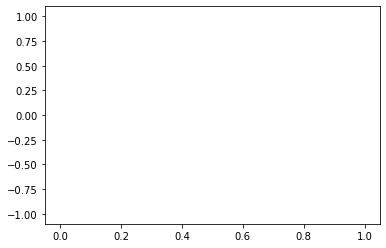

In [13]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

## FV Convergence

In [14]:
wavespeed = 1.0
initial_condition = x_functions.Sine()
final_time = 1.0
exact_solution = advection.ExactSolution(initial_condition, wavespeed)
exact_final_solution = x_functions.FrozenT(exact_solution, final_time)

problem = smooth_scalar_example.SmoothScalarExample(wavespeed, initial_condition)
problem.parameters["final_time"] = final_time
problem.parameters["use_wave_propogation_method"] = True

problem.parameters["basis"]["basis_class"] = "finite_volume"

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["order"] = 1
problem.parameters["time_stepping"]["is_verbose"] = False

problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = 0.0
problem.parameters["mesh"]["x_right"] = 1.0

problem.parameters["fluctuation_solver"]["fluctuation_solver_class"] = "exact_linear"

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"

In [19]:
cfl = dg_utils.standard_cfls(1)
error_list = []
for num_elems in [20, 40]:
    problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, wavespeed, 1.0 / num_elems)
    problem.parameters["mesh"]["num_elems"] = num_elems
    final_solution = main.run(problem)
    error = math_utils.compute_error(final_solution, exact_final_solution)
    error_list.append(error)
order = utils.convergence_order(error_list)
if error_list[-1] >= math_utils.MACHINE_ERROR:
    assert order >= 1
else:
    # This should in fact be exact, only machine error as exactly solving riemann problem
    print(error_list)

[1.0863599218806744e-15, 2.7797933034081654e-15]


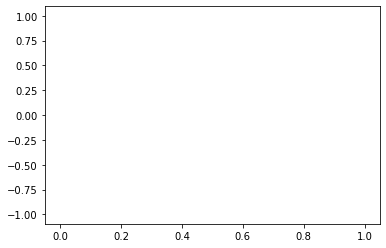

In [18]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())